# Analysis Separately Tcells
## Xiaonan Wang
## 23Aug2017

In [2]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from matplotlib.colors import LinearSegmentedColormap
#cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
def plotMA(adata, unsName, cidx=0, Cells = None, save=False, padj_cutoff=0.05, logFC_cutoff=1, exp_cutoff=-6, s=1):
    if Cells is not None:
        adata_sub = adata[Cells,:]
    else:
        adata_sub = adata
    print(adata_sub.shape)
    gnames = pd.DataFrame(adata.uns[unsName]['names']).iloc[:,cidx]
    logFC = pd.DataFrame(adata.uns[unsName]['logfoldchanges']).iloc[:,cidx]
    pvals = pd.DataFrame(adata.uns[unsName]['pvals']).iloc[:,cidx]
    padj = pd.DataFrame(adata.uns[unsName]['pvals_adj']).iloc[:,cidx]
    adata_sub = adata_sub.raw[:, gnames].X
    print(adata_sub.shape)
    normExp = np.mean(np.exp(adata_sub)-1, axis=0)
    del adata_sub
    #print(len(normExp))
    #print(len(logFC))
    abs_logFC = logFC.copy()
    abs_logFC[abs_logFC > 4] = 4
    abs_logFC[abs_logFC < -4] = -4
    #import seaborn as sns
    #sns.kdeplot(np.log(normExp))
    logExp = np.log2(normExp)
    idx = (padj < padj_cutoff) & (abs(abs_logFC) > logFC_cutoff)
    upidx = (padj < padj_cutoff) & (abs_logFC > logFC_cutoff) & (logExp > exp_cutoff)
    downidx = (padj < padj_cutoff) & (abs_logFC < -logFC_cutoff) & (logExp > exp_cutoff)
    print('upRegulated gene: '+str(sum(upidx)))
    print('downRegulated gene: '+str(sum(downidx)))
    
    fig = plt.figure()
    plt.scatter(x=logExp, y=abs_logFC, s=s)
    plt.scatter(x=logExp[idx & (logExp > exp_cutoff)], y=abs_logFC[idx & (logExp > exp_cutoff)], c='red',s=s)
    plt.axhline(y=0, color='black')
    plt.axhline(y=logFC_cutoff, color='grey', linestyle = '--')
    plt.axhline(y=-logFC_cutoff, color='grey', linestyle = '--')
    plt.axvline(x=exp_cutoff, color='grey', linestyle = '--')
    plt.xlabel('log2 Mean Exp')
    plt.ylabel('log2 Fold Change')
    plt.grid(b=None)
    plt.show()
    if save:
        fig.savefig('../figures/DEres_'+unsName+'_idx_'+str(cidx)+'.pdf')
    
    Ftable = pd.DataFrame(np.column_stack([gnames, logExp, logFC, pvals, padj]), columns=['GN','logMeanExp', 'logFC', 'pvals', 'padj'])
    return gnames[upidx], gnames[downidx], Ftable

In [19]:
%%time
Tcells_data = sc.read("Tcells_cnt.txt", cache=True, delimiter="\t")

CPU times: user 4 ms, sys: 11.2 s, total: 11.2 s
Wall time: 15 s


In [20]:
Tcells_data.var_names = np.genfromtxt("genes.tsv", dtype=str)[:, 1]
Tcells_data.smp_names = np.genfromtxt("Tcells_colnames.txt", dtype=str)
print(Tcells_data.smp_names[0:5])
print(Tcells_data.var_names[0:5])

['C4_AAACCTGAGATCCTGT-1' 'C4_AAACCTGAGCTGCGAA-1' 'C4_AAACCTGAGGGAGTAA-1'
 'C4_AAACCTGCACCCAGTG-1' 'C4_AAACCTGCAGGTGGAT-1']
['MIR1302-10' 'FAM138A' 'OR4F5' 'RP11-34P13.7' 'RP11-34P13.8']


In [21]:
key_labels_Tcells = np.genfromtxt('Tcells_key_labels.txt', delimiter='\t', dtype=str)
# change to proper names
key_labels_Tcells = [w.replace("C4", "D1T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("D4", "D2T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("E4", "D3T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("F4", "D1S") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("G4", "D2S") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("H4", "D3S") for w in key_labels_Tcells]
key_labels_Tcells = np.array(key_labels_Tcells)
print(np.unique(key_labels_Tcells))

['A2' 'D1S' 'D1T' 'D2S' 'D2T' 'D3S' 'D3T']


In [22]:
for k in sorted(np.unique(key_labels_Tcells)):
    print(k)
    new_k = [k if x==k else 'others' for x in key_labels_Tcells]
    Tcells_data.smp['s'+k] = new_k
Tcells_data.smp['key_labels'] = key_labels_Tcells
Tcells_data.smp['Donor_labels'] = [x[:2] for x in key_labels_Tcells]
Tcells_data.smp['Condition_labels'] = [x[-1:] for x in key_labels_Tcells]

A2
D1S
D1T
D2S
D2T
D3S
D3T


In [23]:
mp_labels_Tcells = np.genfromtxt('Tcells_mp_labels.txt', delimiter='\t', dtype=int)
Tcells_data.smp['mp_labels'] = np.log2(mp_labels_Tcells+1)

In [24]:
DT_index = []
DS_index = []

for sp in ['D1T', 'D2T', 'D3T']:
    DT_index.append(np.where(key_labels_Tcells==sp)[0])
DT_index = np.concatenate(DT_index)
print(len(DT_index))

for sp in ['D1S', 'D2S', 'D3S']:
    DS_index.append(np.where(key_labels_Tcells==sp)[0])
DS_index = np.concatenate(DS_index)
print(len(DS_index))

18881
21676


## DT cells

In [32]:
DT_data = Tcells_data[DT_index,]
print(DT_data.X.shape)

(18881, 32738)


### Remove doublet cells

In [10]:
doublet_score = np.genfromtxt('Tcells_doublet_score.txt', delimiter='\t')

In [11]:
doublet_score_DT = doublet_score[DT_index]

In [12]:
doublet_percentage = 2.5
vline = np.percentile(doublet_score_DT, 100-doublet_percentage)
vline_idx = doublet_score_DT<vline
print(len(doublet_score_DT)-sum(vline_idx))

499


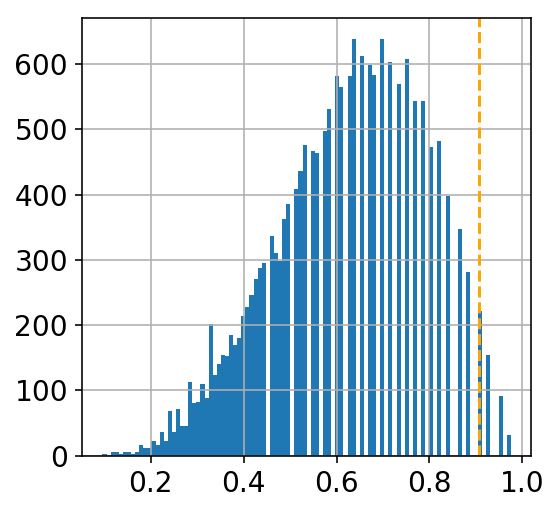

In [13]:
pl.hist(doublet_score_DT, 100)
pl.axvline(x=vline, color='orange', linestyle='--')

### QC

In [33]:
mito_genes = np.array([name for name in DT_data.var_names if name.startswith('MT-')])
#print(np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))
#for each cell compute fraction of counts in mito genes vs. all genes
DT_data.smp['percent_mito'] = np.sum(DT_data[:, mito_genes].X, axis=1) / np.sum(DT_data.X, axis=1)
# add the total counts per cell as sample annotation to adata
DT_data.smp['n_counts'] = np.sum(DT_data.X, axis=1)
DT_data.smp['log2_n_counts'] = np.log2(np.sum(DT_data.X, axis=1))
DT_data.smp['n_genes'] = (DT_data.X!=0).astype(int).sum(axis=1)

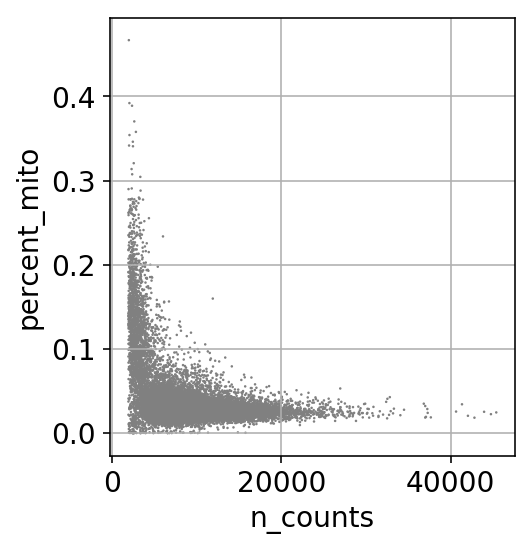

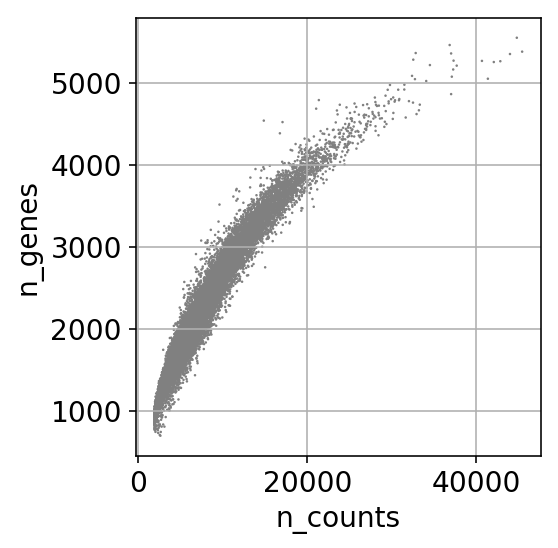

In [15]:
axs = sc.pl.scatter(DT_data, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(DT_data, x='n_counts', y='n_genes')

In [34]:
sc.pp.filter_genes(DT_data, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(DT_data)          # normalize with total UMI count per cell

### Select HVGs

In [17]:
%%time
filter_result_DT = sc.pp.filter_genes_dispersion(DT_data.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 7.16 GB, difference +7.16 GB
CPU times: user 1.75 s, sys: 1.24 s, total: 2.98 s
Wall time: 2.98 s


/home/USSR/xw251/anaconda2/envs/mypython3/lib/python3.6/site-packages/matplotlib/scale.py:103: RuntimeWarning: divide by zero encountered in log
  return np.divide(np.log(a, out=a), np.log(self.base), out=a)


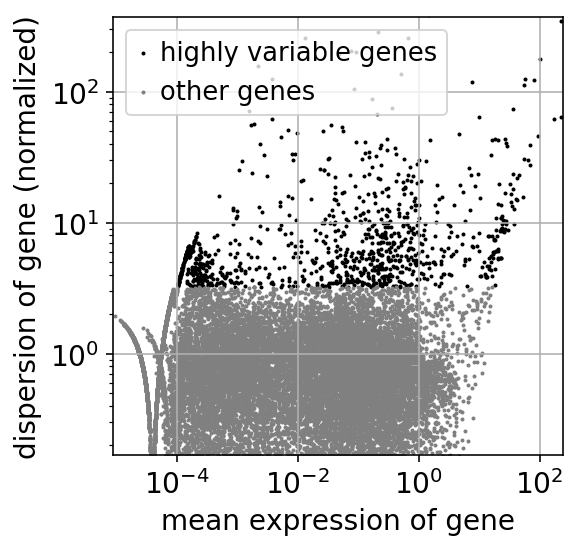

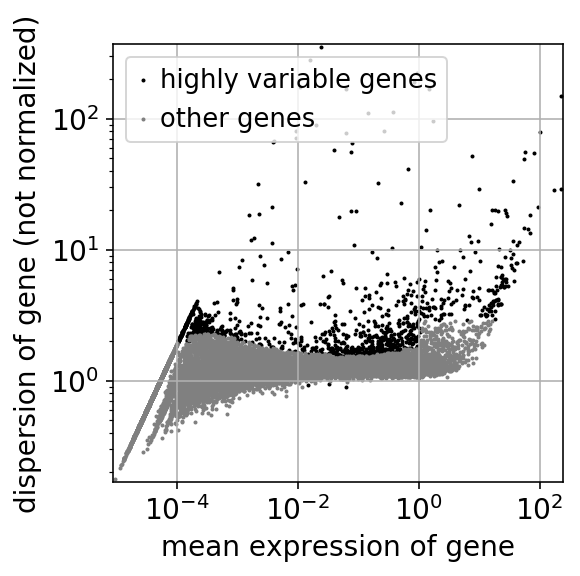

In [18]:
sc.pl.filter_genes_dispersion(filter_result_DT, log=True)

In [19]:
DT_data = DT_data[:, filter_result_DT.gene_subset] 

In [20]:
%%time
sc.pp.log1p(DT_data)
DT_data_corrected = sc.pp.regress_out(DT_data, ['n_counts', 'percent_mito'], copy=True)
sc.pp.scale(DT_data_corrected)
sc.logging.print_memory_usage()

Widget Javascript not detected.  It may not be installed or enabled properly.



Memory usage: current 5.95 GB, difference -1.22 GB
CPU times: user 2min 37s, sys: 2.86 s, total: 2min 40s
Wall time: 3min 1s


### PCA

In [21]:
%%time
sc.tl.pca(DT_data_corrected, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 6.01 GB, difference +0.06 GB
CPU times: user 52.8 s, sys: 2.02 s, total: 54.8 s
Wall time: 9.28 s


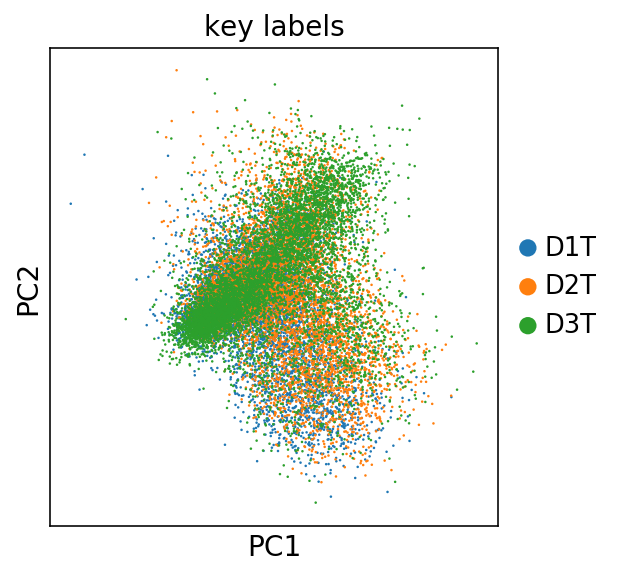

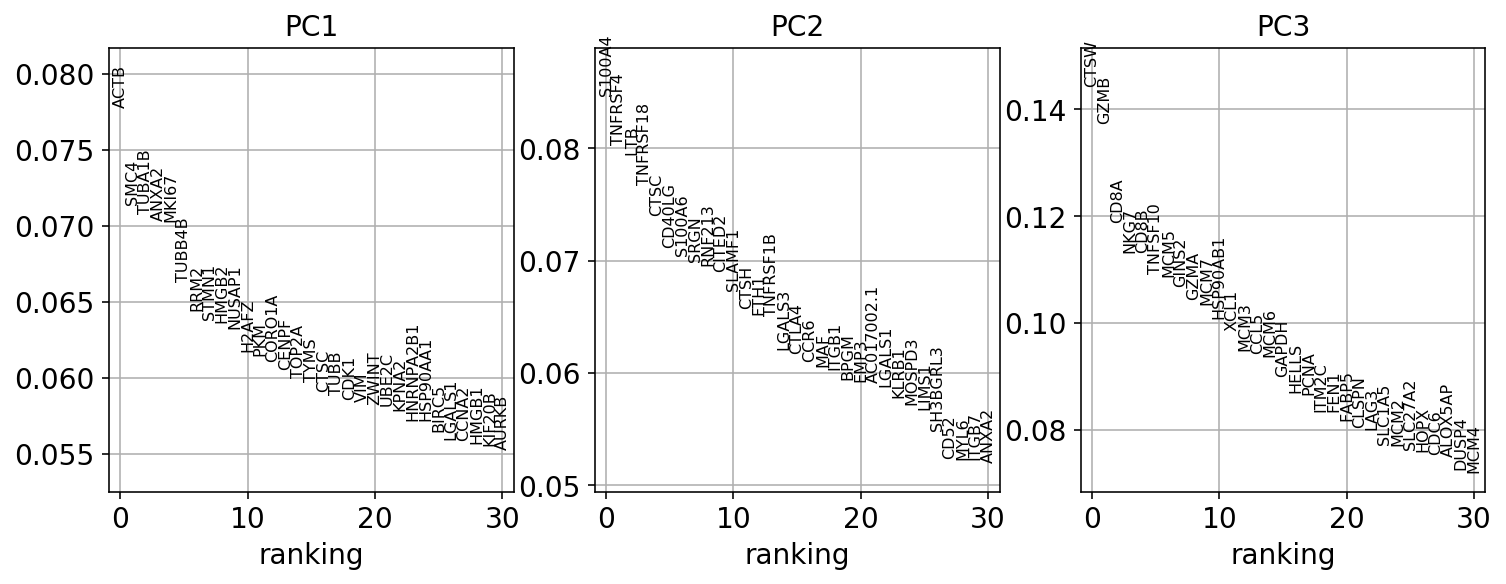

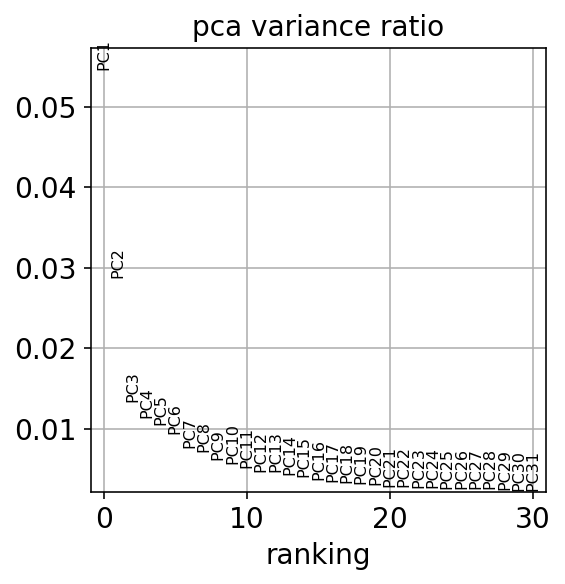

In [22]:
sc.pl.pca(DT_data_corrected, components= '1,2', color='key_labels')

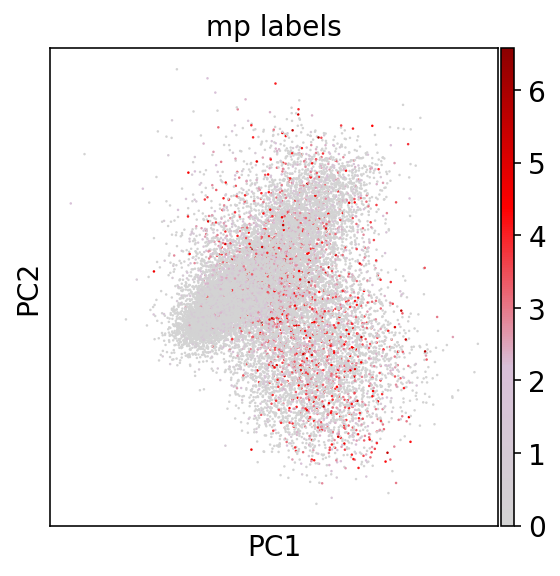

In [23]:
sc.pl.pca_scatter(DT_data_corrected, components= '1,2', color='mp_labels', color_map=cmap)

### TSNE

In [24]:
%%time
sc.tl.tsne(DT_data_corrected,n_jobs=40)
sc.logging.print_memory_usage()

Memory usage: current 6.05 GB, difference +0.04 GB
CPU times: user 20min 41s, sys: 38min 43s, total: 59min 24s
Wall time: 1min 37s


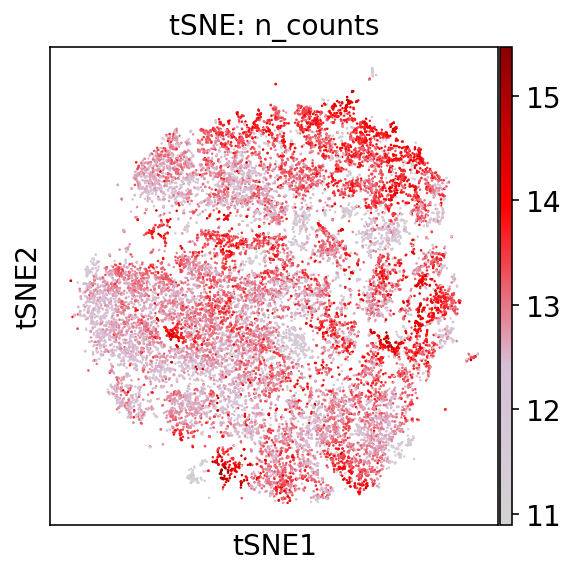

In [25]:
ax = sc.pl.tsne(DT_data_corrected, color=['log2_n_counts'], legend_loc='on data', title='tSNE: n_counts', color_map=cmap)

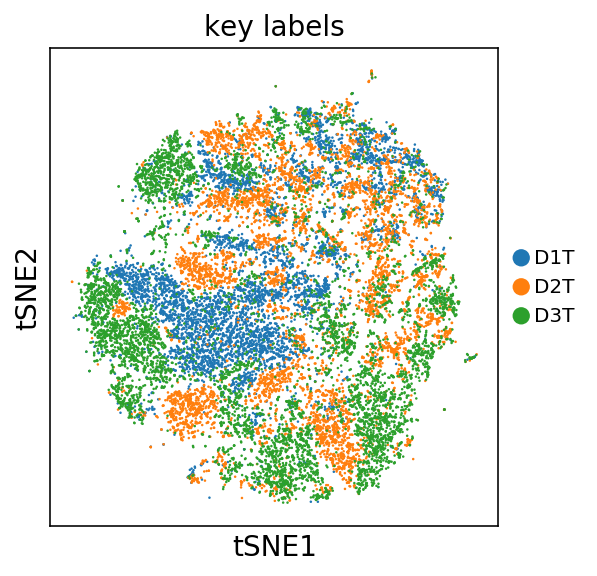

In [26]:
axs = sc.pl.tsne(DT_data_corrected, color='key_labels', legend_loc='right margin', legend_fontsize=10)

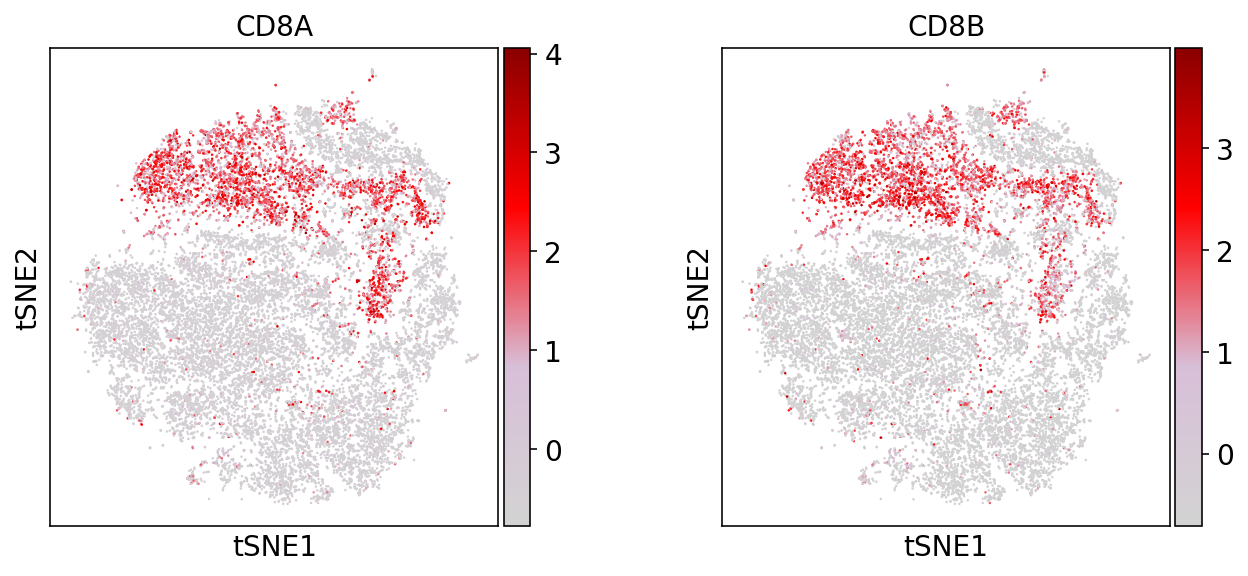

In [27]:
axs = sc.pl.tsne(DT_data_corrected, color=['CD8A', 'CD8B'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

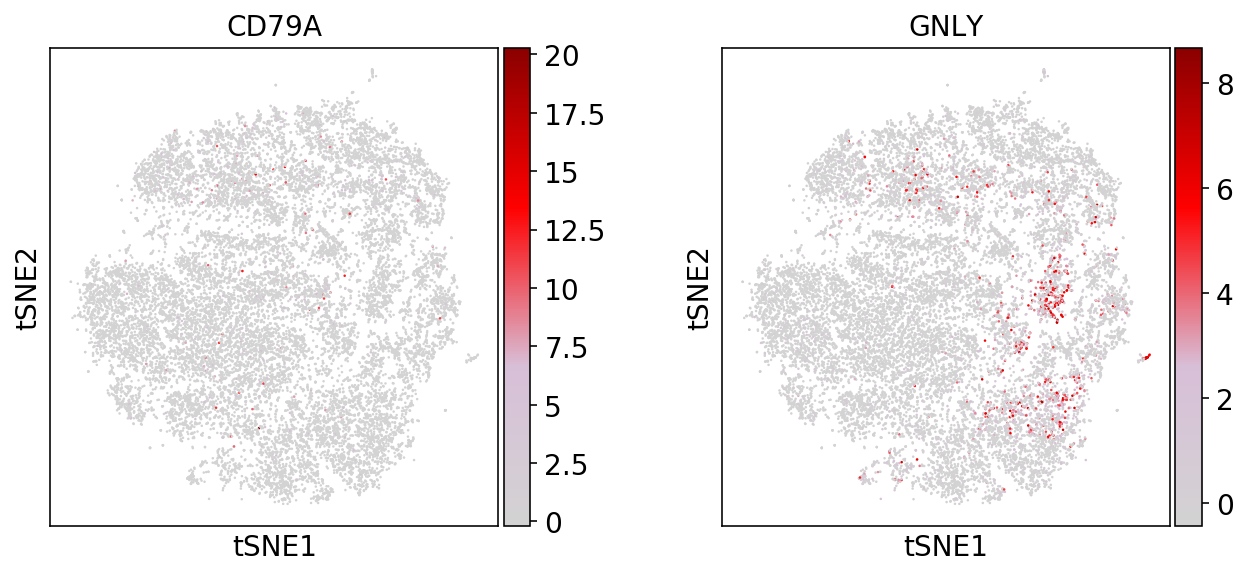

In [28]:
axs = sc.pl.tsne(DT_data_corrected, color=['CD79A', 'GNLY'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

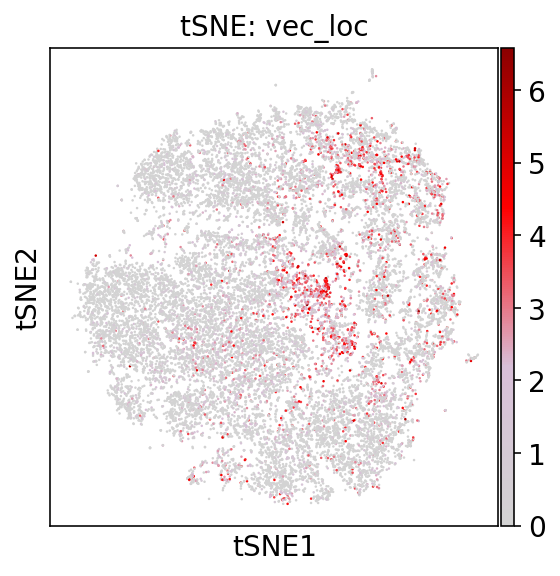

In [29]:
ax = sc.pl.tsne(DT_data_corrected, color=['mp_labels'], legend_loc='right margin', title='tSNE: vec_loc', color_map=cmap)

### Louvain clustering

In [2]:
DT_data_corrected = sc.read('DT_data_OL_corrected')

In [9]:
%%time
sc.tl.louvain(DT_data_corrected, n_jobs=40, resolution=0.4)
sc.logging.print_memory_usage()

Memory usage: current 0.31 GB, difference +0.00 GB
CPU times: user 16.4 s, sys: 120 ms, total: 16.5 s
Wall time: 16.5 s


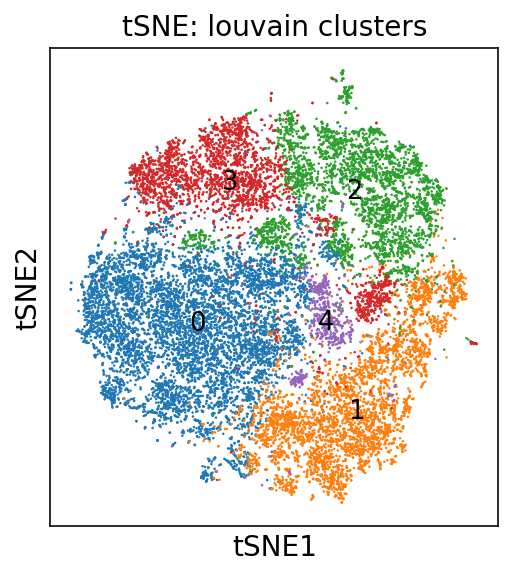

In [10]:
ax = sc.pl.tsne(DT_data_corrected, color=['louvain_groups'], legend_loc='on data', title='tSNE: louvain clusters')

### DE analysis1

In [3]:
DT_data = sc.read('../write_new/DT_data_OL_corrected.h5ad', cache=True)

In [5]:
sc.tl.rank_genes_groups(DT_data, 'Louvain_Clusters', n_genes=DT_data.raw.shape[1], key_added='DE_cluster')

ranking genes
    finished: added to `.uns['DE_cluster']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:07:02)


In [6]:
pd.DataFrame(DT_data.uns['DE_cluster']['names']).head(10)

L2-1      L2-2      L2-3   L2-4    L2-5
0   RPL10      CTSH    TUBA1B   CD8B   DUSP4
1   RPS14    S100A4      TUBB   CD8A   CFLAR
2   RPL34      FTH1     STMN1   CTSW   ZBED2
3    RPS2     OSTF1      TYMS   NKG7   IL2RA
4  EEF1A1  TNFRSF18     HMGB2   GZMB  ARID5A
5    RPL3     ANXA2     H2AFZ   HCST     CD2
6   RPL13      CD59     MKI67   GZMA   BIRC3
7  RPL13A    RNF213  KIAA0101  COTL1     PKM
8   RPS27     CMTM6      SMC4   LAG3   TRAF1
9   RPL14     ITGB1     HMGB1   REG4     EED

(18881, 1332)
(18881, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 86
downRegulated gene: 869


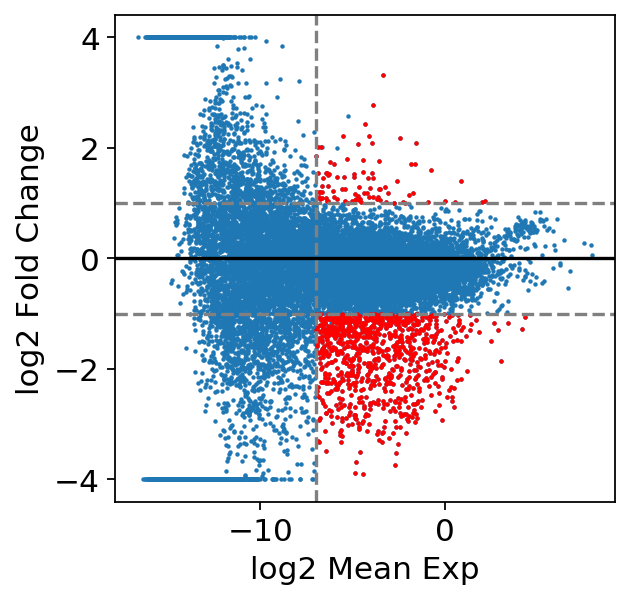

(18881, 1332)
(18881, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 455
downRegulated gene: 450


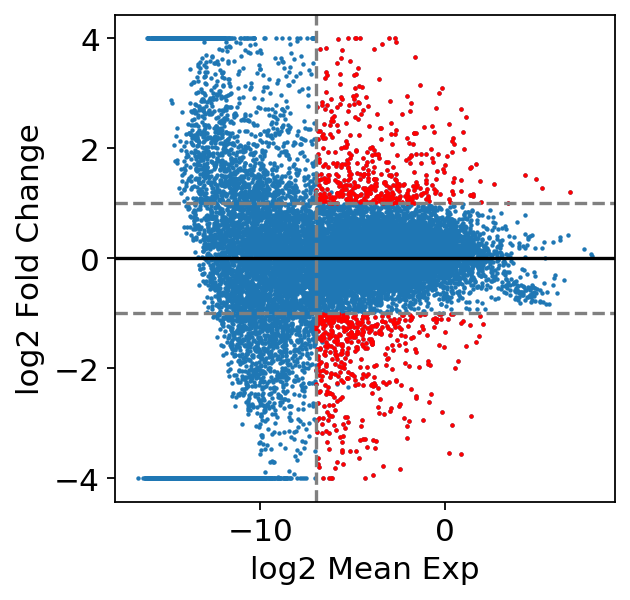

(18881, 1332)
(18881, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 658
downRegulated gene: 215


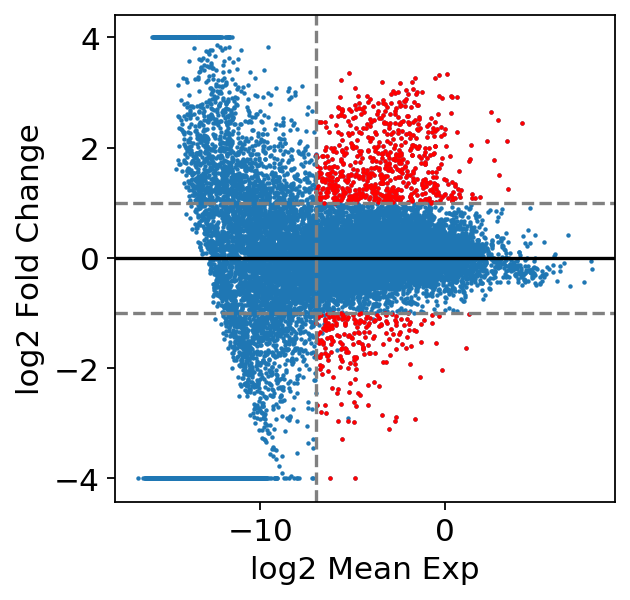

(18881, 1332)
(18881, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 177
downRegulated gene: 353


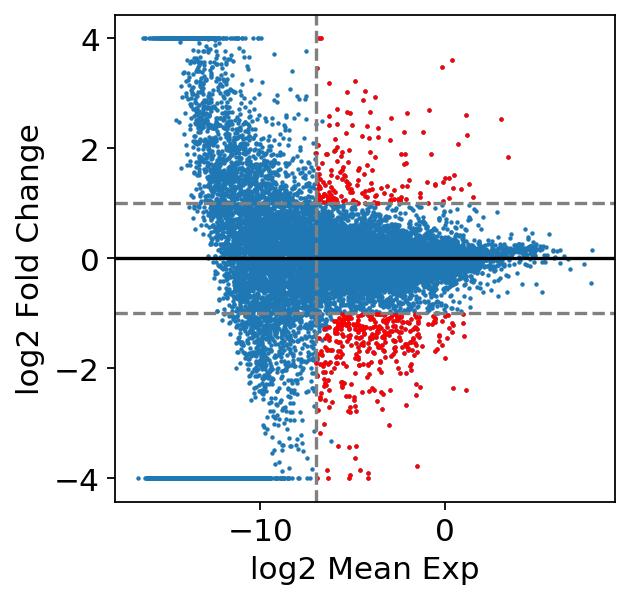

(18881, 1332)
(18881, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 438
downRegulated gene: 194


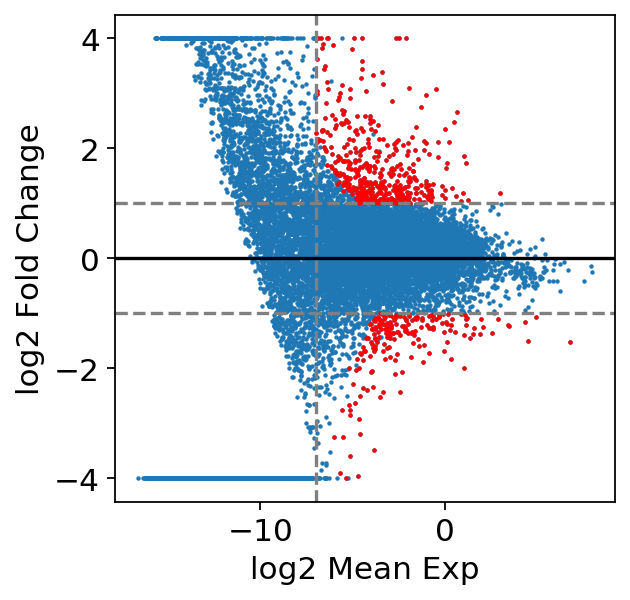

In [4]:
for idx,cl in enumerate(DT_data.obs['Louvain_Clusters'].cat.categories):
    upG, downG, tableG = plotMA(DT_data, 'DE_cluster',save=True, cidx=idx, padj_cutoff=0.05, logFC_cutoff=1, exp_cutoff=-7)
    np.savetxt('../DEres/DT_cluster/c'+cl+'vsAll_upG.txt', upG, delimiter='\t', fmt='%s')
    np.savetxt('../DEres/DT_cluster/c'+cl+'vsAll_downG.txt', downG, delimiter='\t', fmt='%s')
    tableG.to_csv('../DEres/DT_cluster/c'+cl+'vsAll_table.csv')

In [20]:
DT_data.write('../write_new/DT_data_OL_corrected.h5ad')

In [24]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('../DEres/DT_cluster') if ((isfile(join('../DEres/DT_cluster', f))) & ('upG' in f))]

In [109]:
geneDEtop10 = np.concatenate([pd.read_csv('../DEres/DT_cluster/'+f).iloc[0:10,:].values.flatten() for f in onlyfiles])

In [110]:
geneDEtop10 = ['PRF1' if x == 'CD8A' else x for x in geneDEtop10 ]

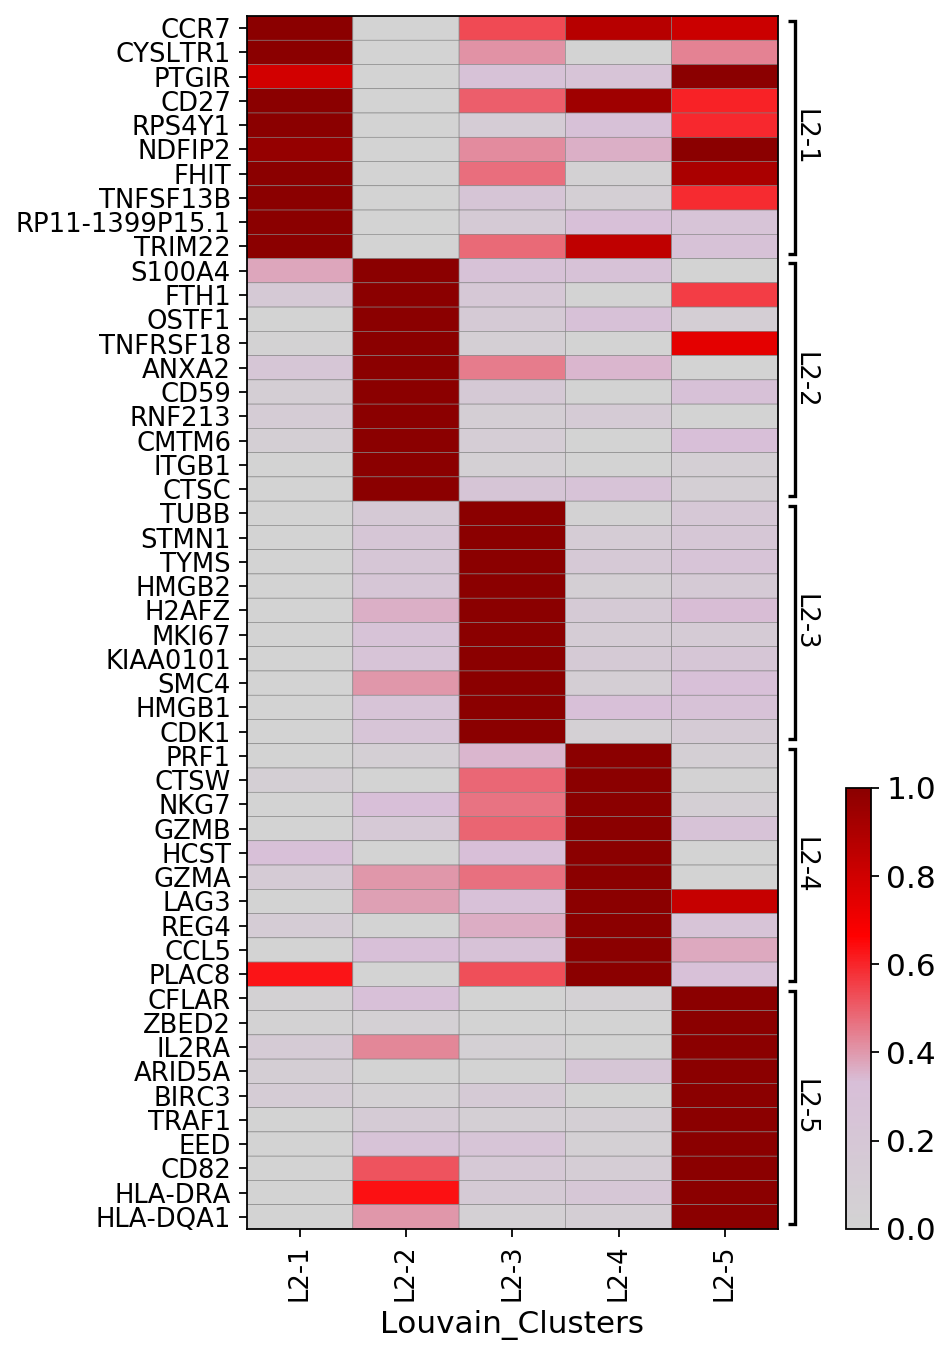

GridSpec(2, 3, height_ratios=[0, 10], width_ratios=[4.4, 0.4, 0.2])

In [112]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

gpos = [(0,9), (10,19), (20,29), (30,39), (40,49)]
glabel = DT_data.obs['Louvain_Clusters'].cat.categories
sc.pl.matrixplot(DT_data, geneDEtop10, groupby = 'Louvain_Clusters', 
                 dendrogram=False, swap_axes=True, standard_scale='var', cmap=cmap,
                var_group_positions = gpos,
                var_group_labels=glabel, figsize=(5,10), save='_DT_cluster.pdf')

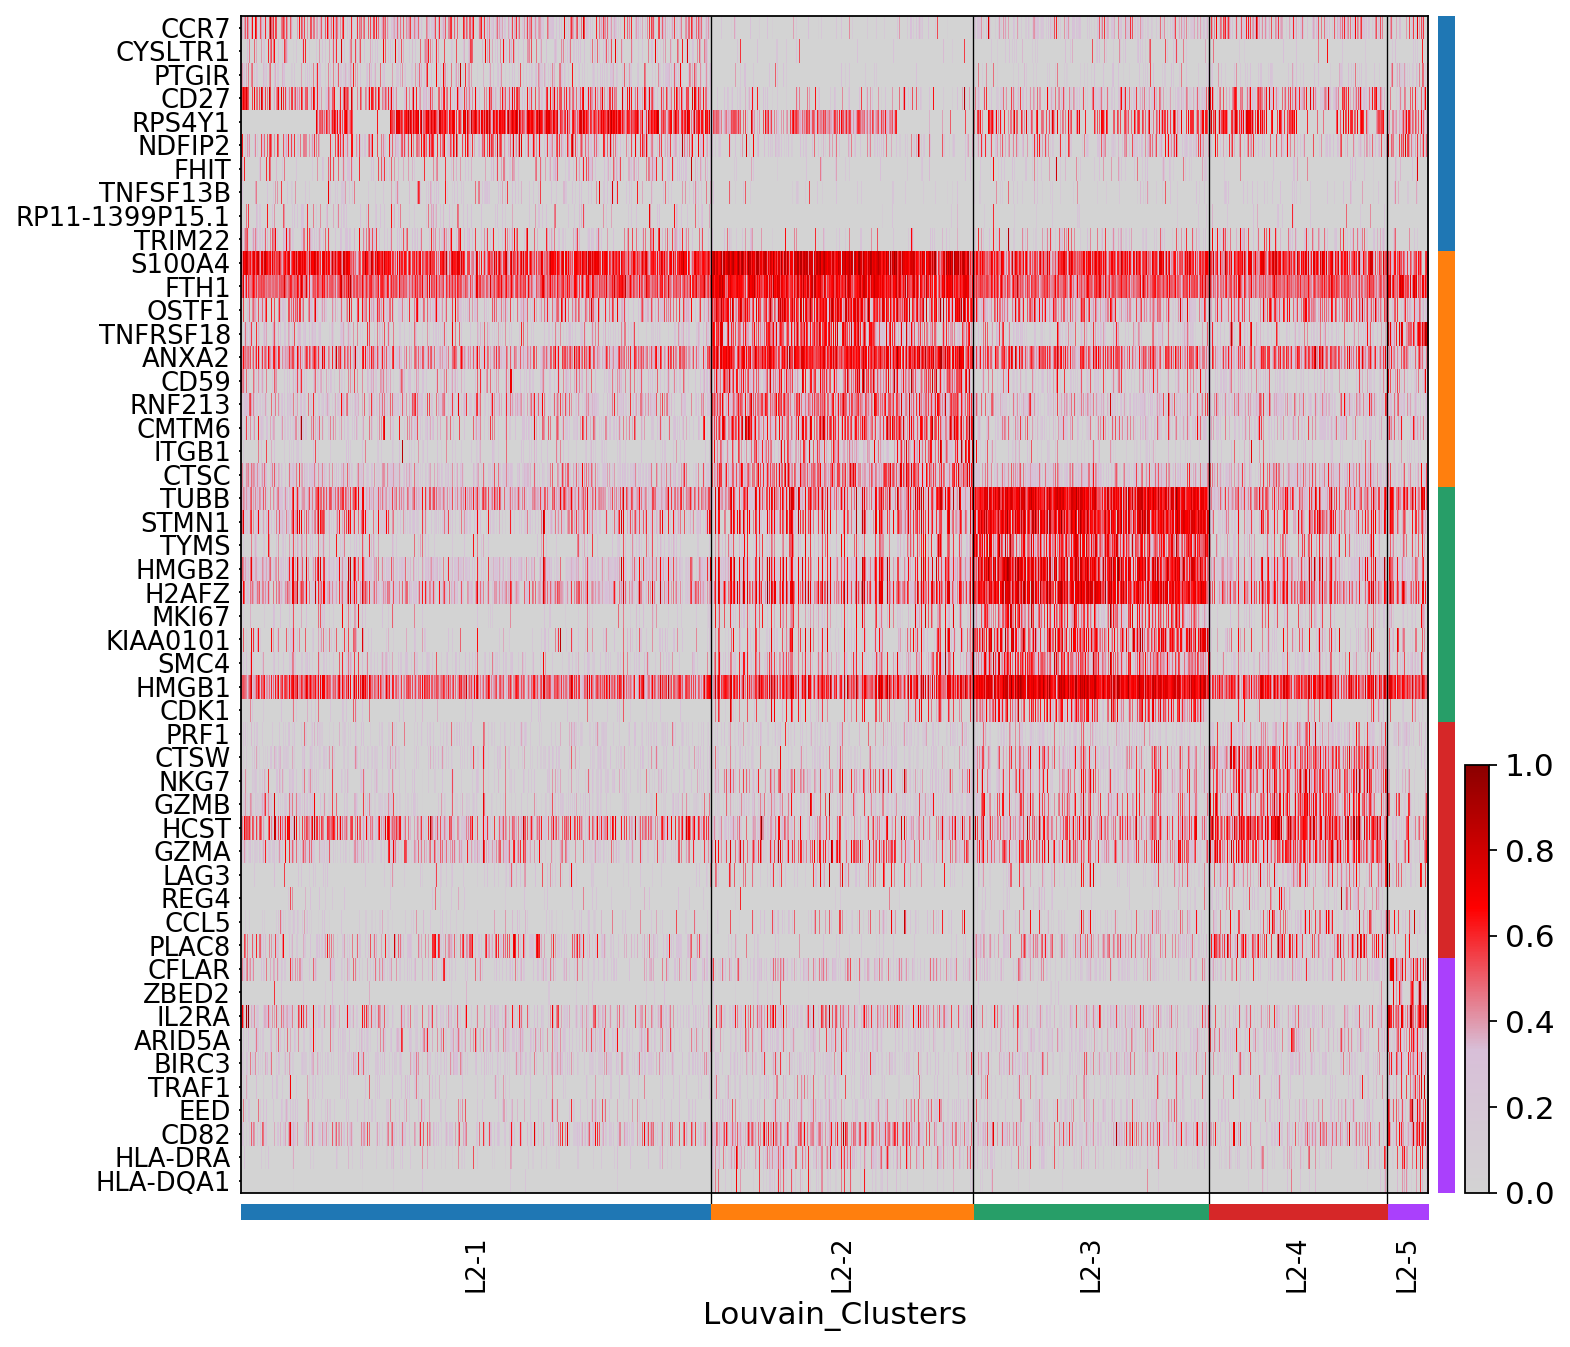

GridSpec(3, 3, height_ratios=[0, 9.87, 0.13], width_ratios=[10, 0.14, 0.2])

In [113]:
sc.pl.heatmap(DT_data, geneDEtop10, groupby = 'Louvain_Clusters', 
                 dendrogram=False, swap_axes=True, standard_scale='var', cmap=cmap,
                var_group_positions = gpos,
                var_group_labels=glabel,figsize=(10,10), save='_DT_cluster.pdf')

## DS cells

In [36]:
DS_data = Tcells_data[DS_index,]
print(DS_data.X.shape)

(21676, 32738)


### Remove doublet cells

In [47]:
doublet_score_DS = doublet_score[DS_index]

In [48]:
doublet_percentage = 2.5
vline = np.percentile(doublet_score_DS, 100-doublet_percentage)
vline_idx = doublet_score_DS<vline
print(len(doublet_score_DS)-sum(vline_idx))

700


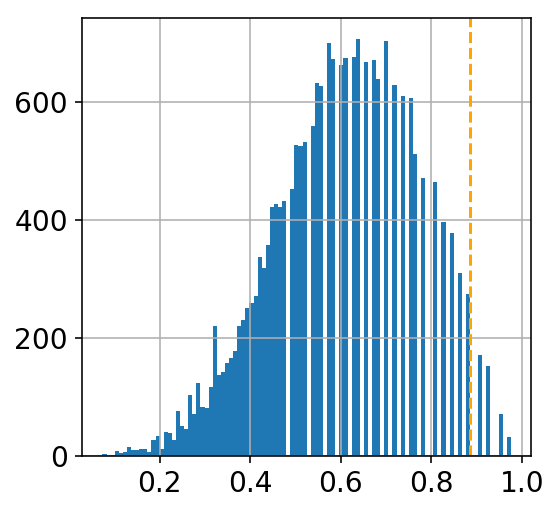

In [49]:
pl.hist(doublet_score_DS, 100)
pl.axvline(x=vline, color='orange', linestyle='--')

### QC

In [37]:
mito_genes = np.array([name for name in DS_data.var_names if name.startswith('MT-')])
#print(np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))
#for each cell compute fraction of counts in mito genes vs. all genes
DS_data.smp['percent_mito'] = np.sum(DS_data[:, mito_genes].X, axis=1) / np.sum(DS_data.X, axis=1)
# add the total counts per cell as sample annotation to adata
DS_data.smp['n_counts'] = np.sum(DS_data.X, axis=1)
DS_data.smp['log2_n_counts'] = np.log2(np.sum(DS_data.X, axis=1))
DS_data.smp['n_genes'] = (DS_data.X!=0).astype(int).sum(axis=1)

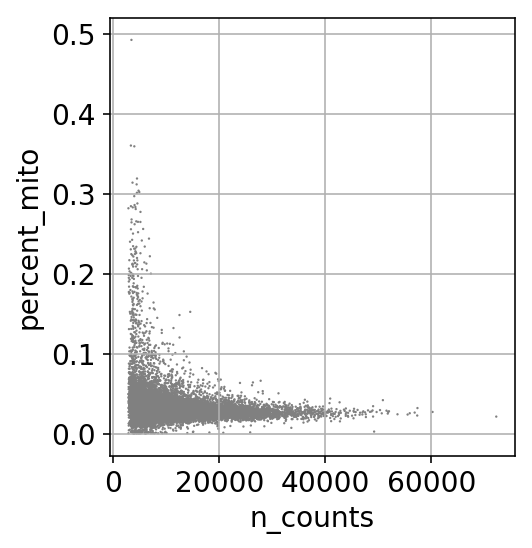

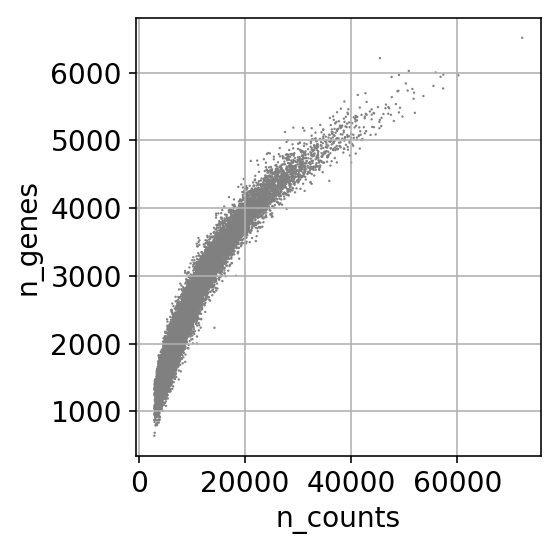

In [51]:
axs = sc.pl.scatter(DS_data, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(DS_data, x='n_counts', y='n_genes')

In [38]:
sc.pp.filter_genes(DS_data, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(DS_data)          # normalize with total UMI count per cell

### Select HVGs

In [53]:
%%time
filter_result_DS = sc.pp.filter_genes_dispersion(DS_data.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 15.69 GB, difference +1.61 GB
CPU times: user 2.5 s, sys: 1.78 s, total: 4.29 s
Wall time: 4.29 s


/home/USSR/xw251/anaconda2/envs/mypython3/lib/python3.6/site-packages/matplotlib/scale.py:103: RuntimeWarning: divide by zero encountered in log
  return np.divide(np.log(a, out=a), np.log(self.base), out=a)


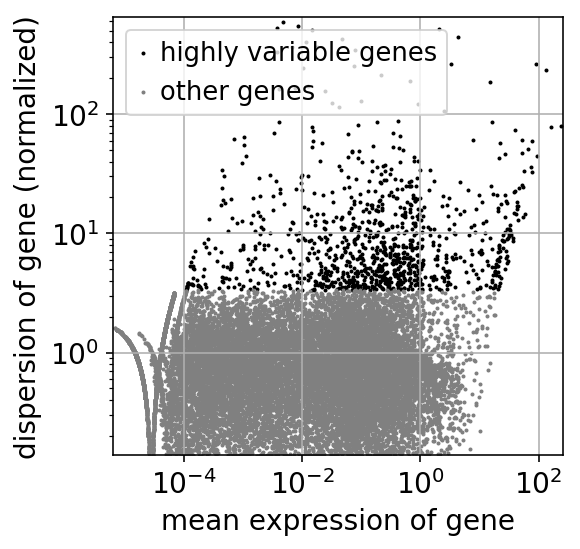

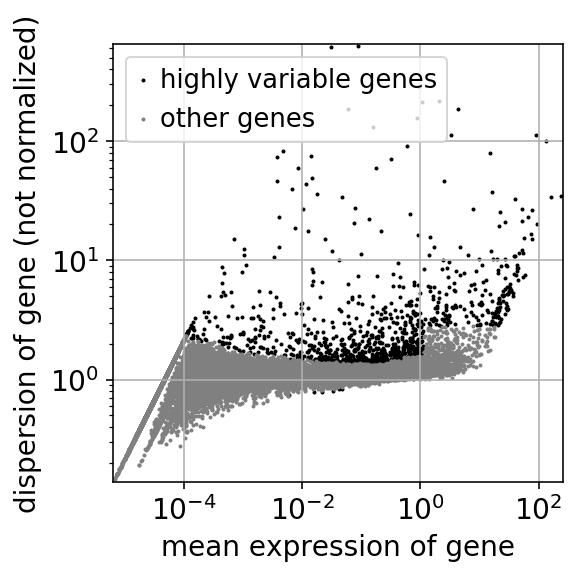

In [54]:
sc.pl.filter_genes_dispersion(filter_result_DS, log=True)

In [55]:
DS_data = DS_data[:, filter_result_DS.gene_subset] 

In [56]:
%%time
sc.pp.log1p(DS_data)
DS_data_corrected = sc.pp.regress_out(DS_data, ['n_counts', 'percent_mito'], copy=True)
sc.pp.scale(DS_data_corrected)
sc.logging.print_memory_usage()

Widget Javascript not detected.  It may not be installed or enabled properly.



Memory usage: current 14.24 GB, difference -1.45 GB
CPU times: user 3min 1s, sys: 3.36 s, total: 3min 5s
Wall time: 3min 28s


### PCA

In [57]:
%%time
sc.tl.pca(DS_data_corrected, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 14.28 GB, difference +0.03 GB
CPU times: user 55.9 s, sys: 1.79 s, total: 57.7 s
Wall time: 10.2 s


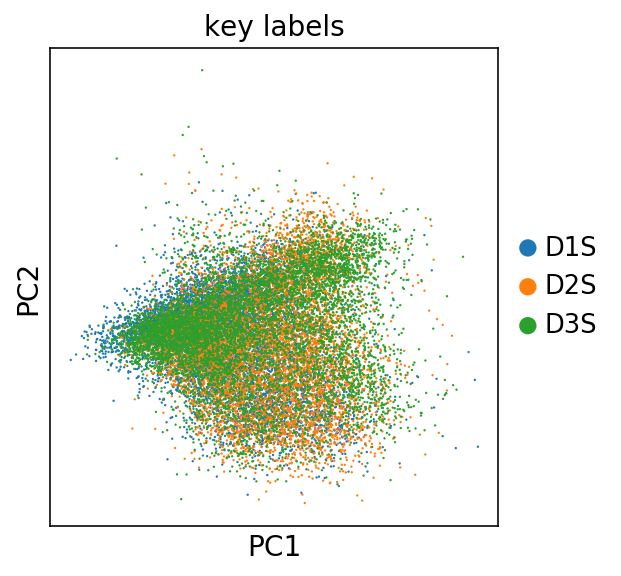

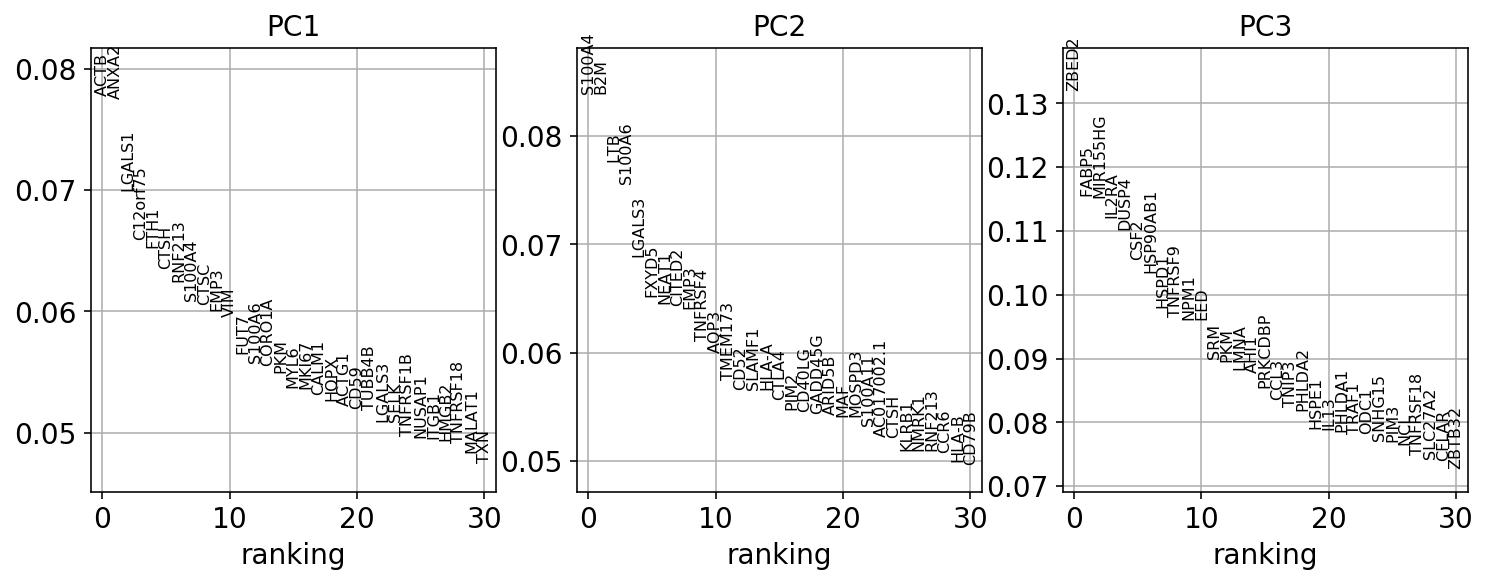

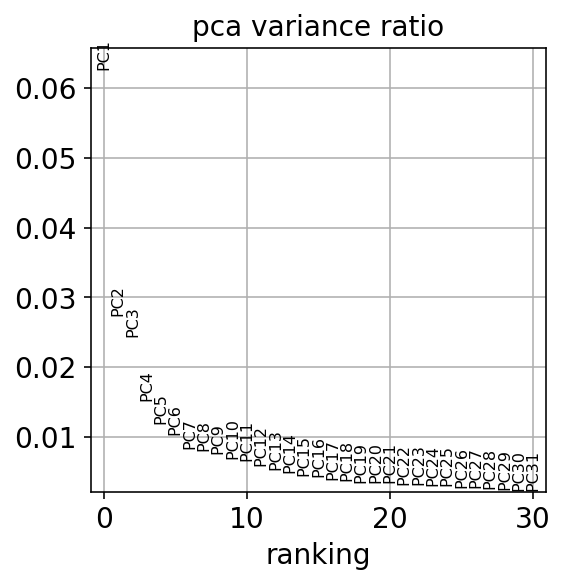

In [58]:
sc.pl.pca(DS_data_corrected, components= '1,2', color='key_labels')

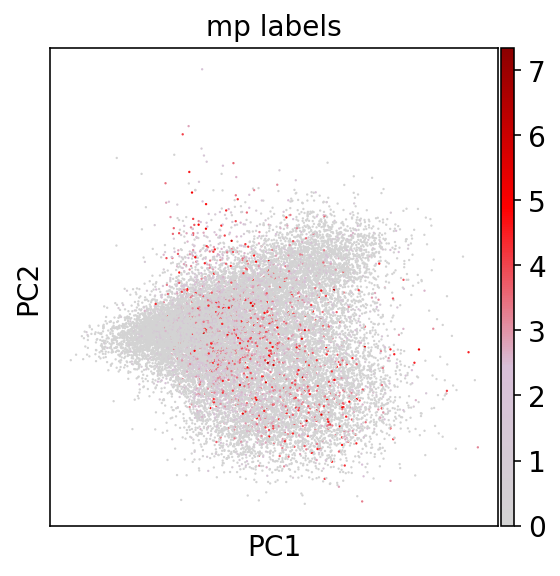

In [59]:
sc.pl.pca_scatter(DS_data_corrected, components= '1,2', color='mp_labels', color_map=cmap)

### TSNE

In [60]:
%%time
sc.tl.tsne(DS_data_corrected,n_jobs=40)
sc.logging.print_memory_usage()

Memory usage: current 14.28 GB, difference +0.01 GB
CPU times: user 23min 17s, sys: 45min 5s, total: 1h 8min 22s
Wall time: 1min 53s


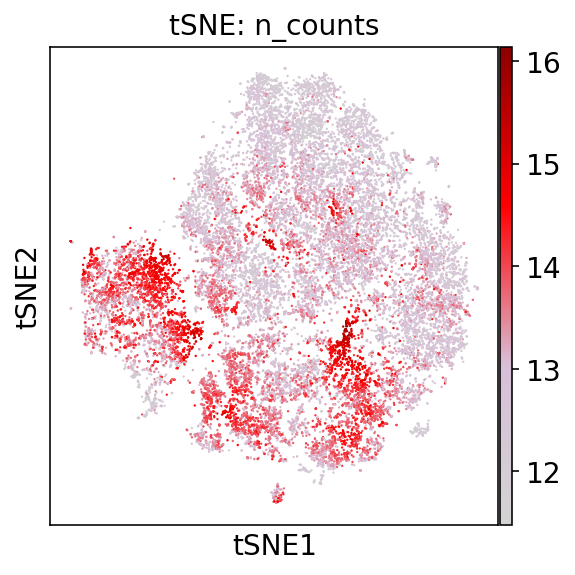

In [61]:
ax = sc.pl.tsne(DS_data_corrected, color=['log2_n_counts'], legend_loc='on data', title='tSNE: n_counts', color_map=cmap)

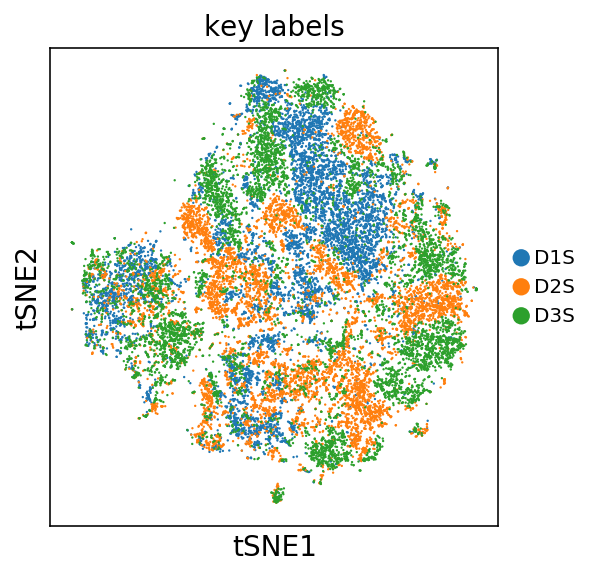

In [62]:
axs = sc.pl.tsne(DS_data_corrected, color='key_labels', legend_loc='right margin', legend_fontsize=10)

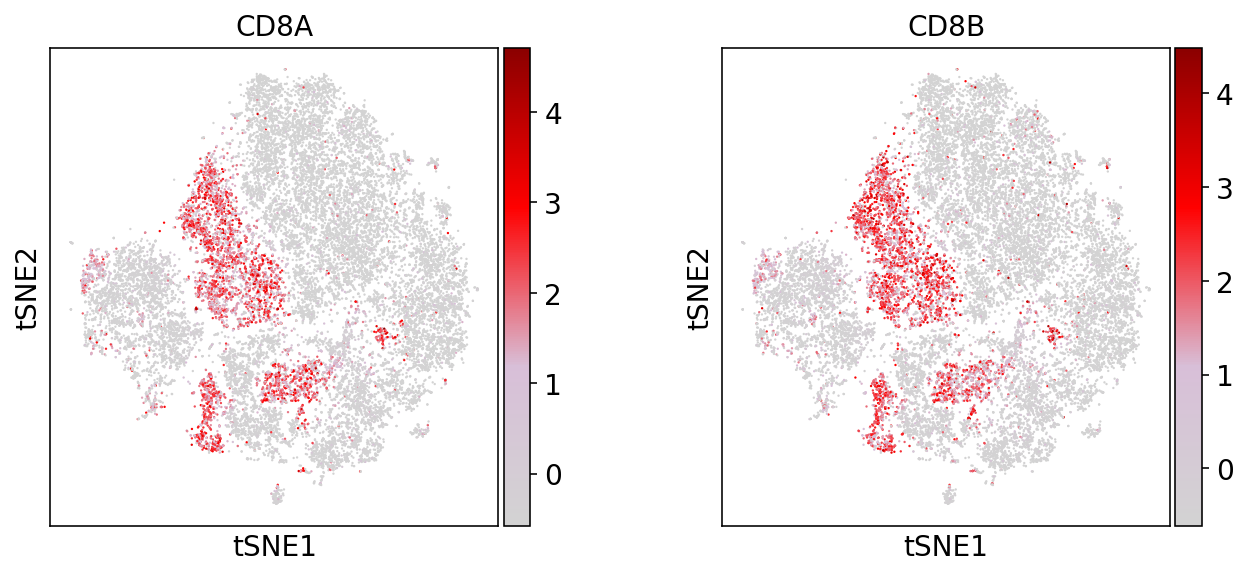

In [63]:
axs = sc.pl.tsne(DS_data_corrected, color=['CD8A', 'CD8B'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

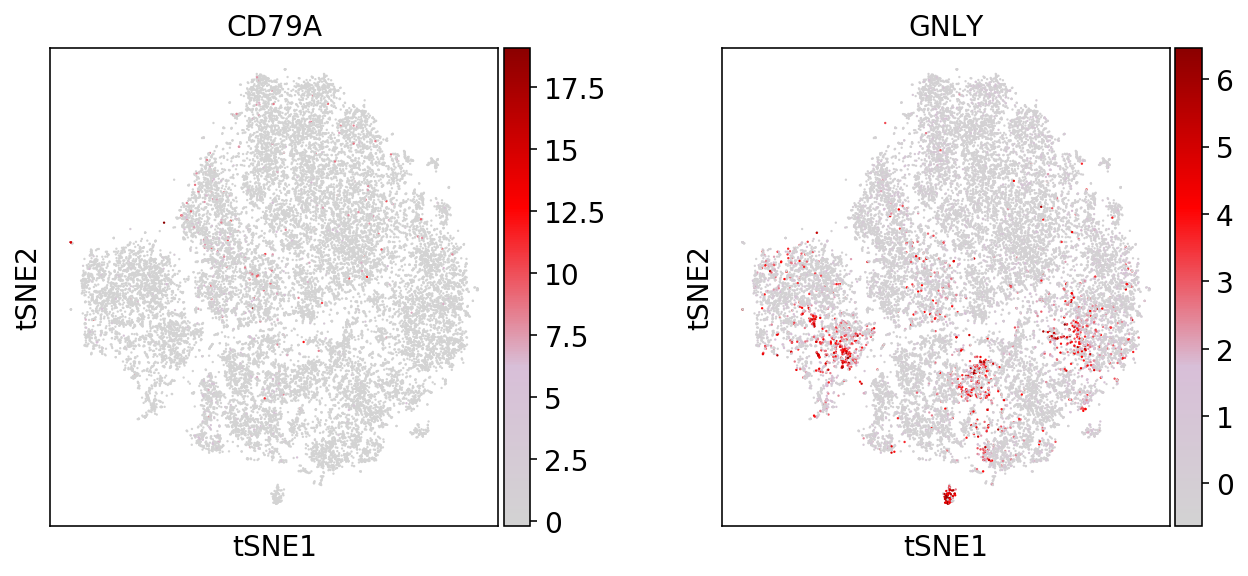

In [64]:
axs = sc.pl.tsne(DS_data_corrected, color=['CD79A', 'GNLY'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

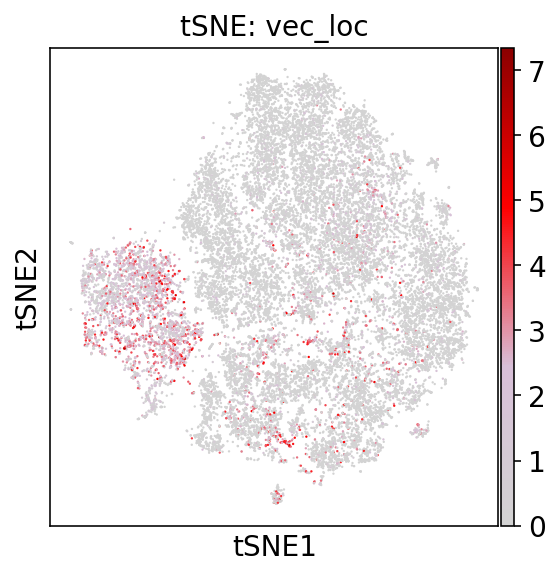

In [65]:
ax = sc.pl.tsne(DS_data_corrected, color=['mp_labels'], legend_loc='right margin', title='tSNE: vec_loc', color_map=cmap)

### Louvain clustering

In [13]:
DS_data_corrected = sc.read('DS_data_OL_corrected')

In [20]:
%%time
sc.tl.louvain(DS_data_corrected, n_jobs=40, resolution=0.4)
sc.logging.print_memory_usage()

Memory usage: current 0.48 GB, difference +0.00 GB
CPU times: user 27.9 s, sys: 216 ms, total: 28.1 s
Wall time: 28.1 s


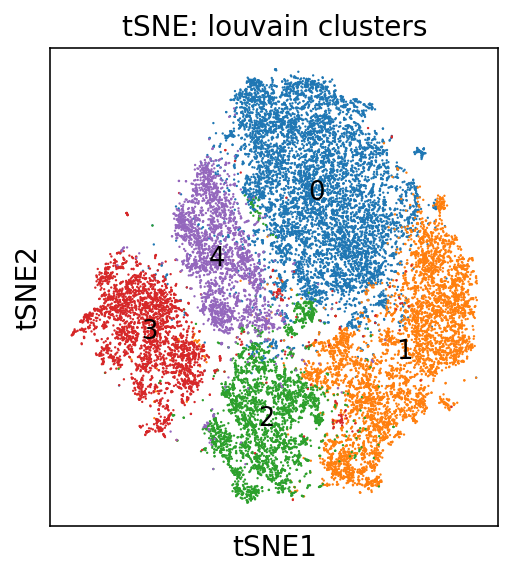

In [21]:
ax = sc.pl.tsne(DS_data_corrected, color=['louvain_groups'], legend_loc='on data', title='tSNE: louvain clusters')

### DE analysis1

In [4]:
DS_data = sc.read('../write_new/DS_data_OL_corrected.h5ad', cache=True)

In [5]:
sc.tl.rank_genes_groups(DS_data, 'Louvain_Clusters', n_genes=DS_data.raw.shape[1], key_added='DE_cluster')

ranking genes
    finished: added to `.uns['DE_cluster']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


In [6]:
pd.DataFrame(DS_data.uns['DE_cluster']['names']).head(10)

L3-1    L3-2    L3-3      L3-4    L3-5
0   RPL10    CTSH   HMGB2     ZBED2    CD8B
1   RPS27   OSTF1   STMN1     FABP5    CD8A
2   RPS14  RNF213  TUBA1B  HSP90AB1    CTSW
3   RPL34   ANXA2   MKI67     HSPD1    HCST
4   RPS28    FTH1   UBE2C      NPM1    GZMM
5  EEF1A1  S100A4    TUBB      NME1    NKG7
6   RPL31  LGALS3   CENPF     IL2RA     CD7
7   RPL13   ITGB1   H2AFZ     HSPE1  IFITM2
8   RPL41    FUT7    SMC4     DUSP4    XCL1
9   RPS25     EBP   TOP2A       SRM   PLAC8

(21676, 1332)
(21676, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 84
downRegulated gene: 1248


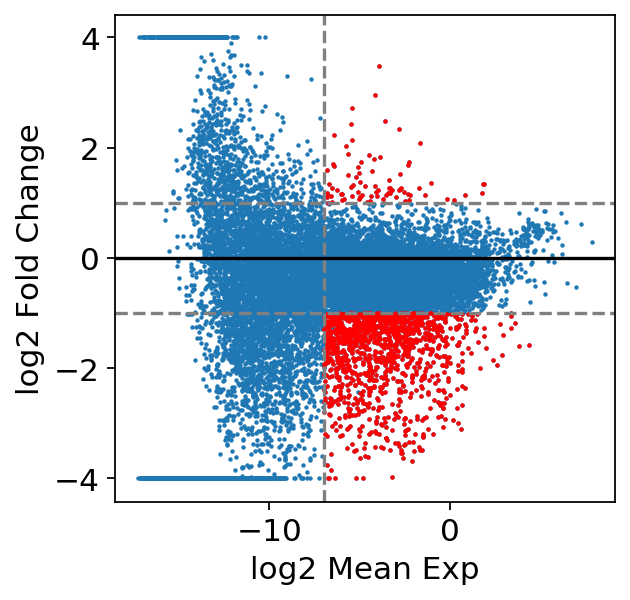

(21676, 1332)
(21676, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 458
downRegulated gene: 386


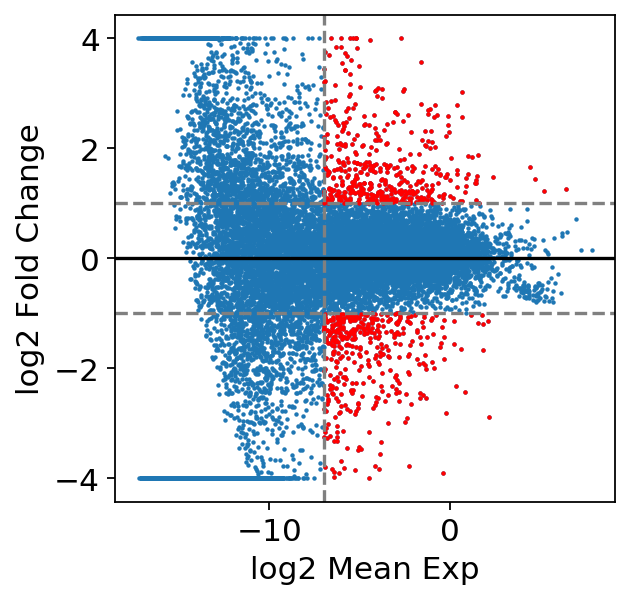

(21676, 1332)
(21676, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 452
downRegulated gene: 208


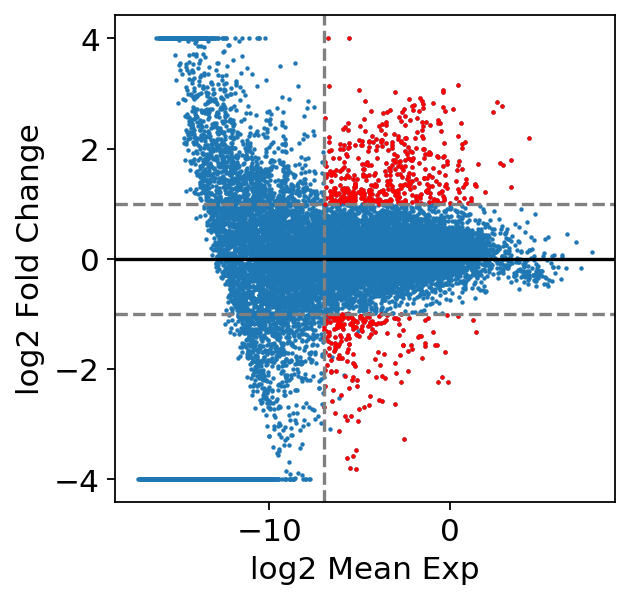

(21676, 1332)
(21676, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 1185
downRegulated gene: 643


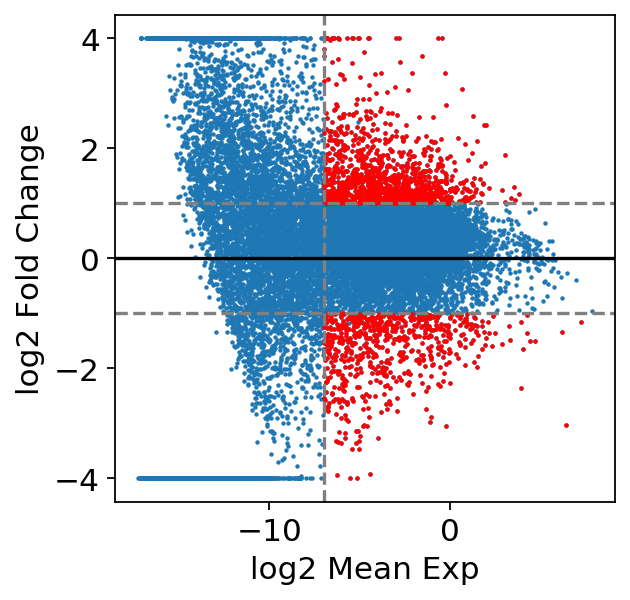

(21676, 1332)
(21676, 21800)


/home/USSR/xw251/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log2


upRegulated gene: 240
downRegulated gene: 516


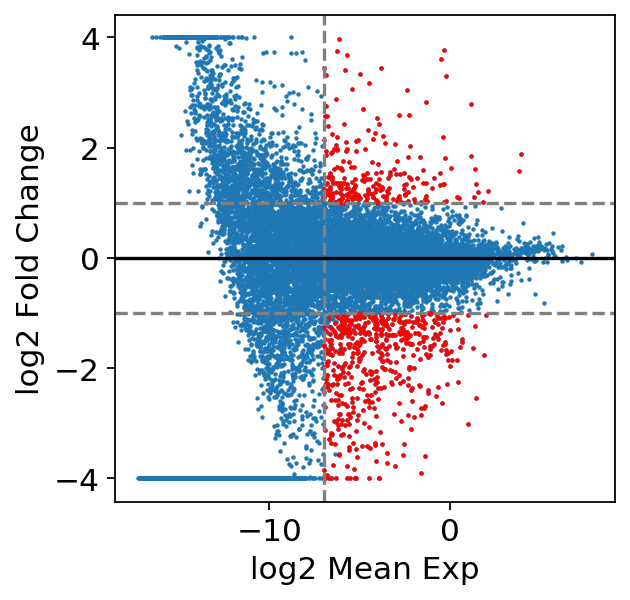

In [7]:
for idx,cl in enumerate(DS_data.obs['Louvain_Clusters'].cat.categories):
    upG, downG, tableG = plotMA(DS_data, 'DE_cluster',save=True, cidx=idx, padj_cutoff=0.05, logFC_cutoff=1, exp_cutoff=-7)
    np.savetxt('../DEres/DS_cluster/c'+cl+'vsAll_upG.txt', upG, delimiter='\t', fmt='%s')
    np.savetxt('../DEres/DS_cluster/c'+cl+'vsAll_downG.txt', downG, delimiter='\t', fmt='%s')
    tableG.to_csv('../DEres/DS_cluster/c'+cl+'vsAll_table.csv')
DS_data.write('../write_new/DS_data_OL_corrected.h5ad')

In [8]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('../DEres/DS_cluster') if ((isfile(join('../DEres/DS_cluster', f))) & ('upG' in f))]
geneDEtop10 = np.concatenate([pd.read_csv('../DEres/DS_cluster/'+f).iloc[0:10,:].values.flatten() for f in onlyfiles])

In [9]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

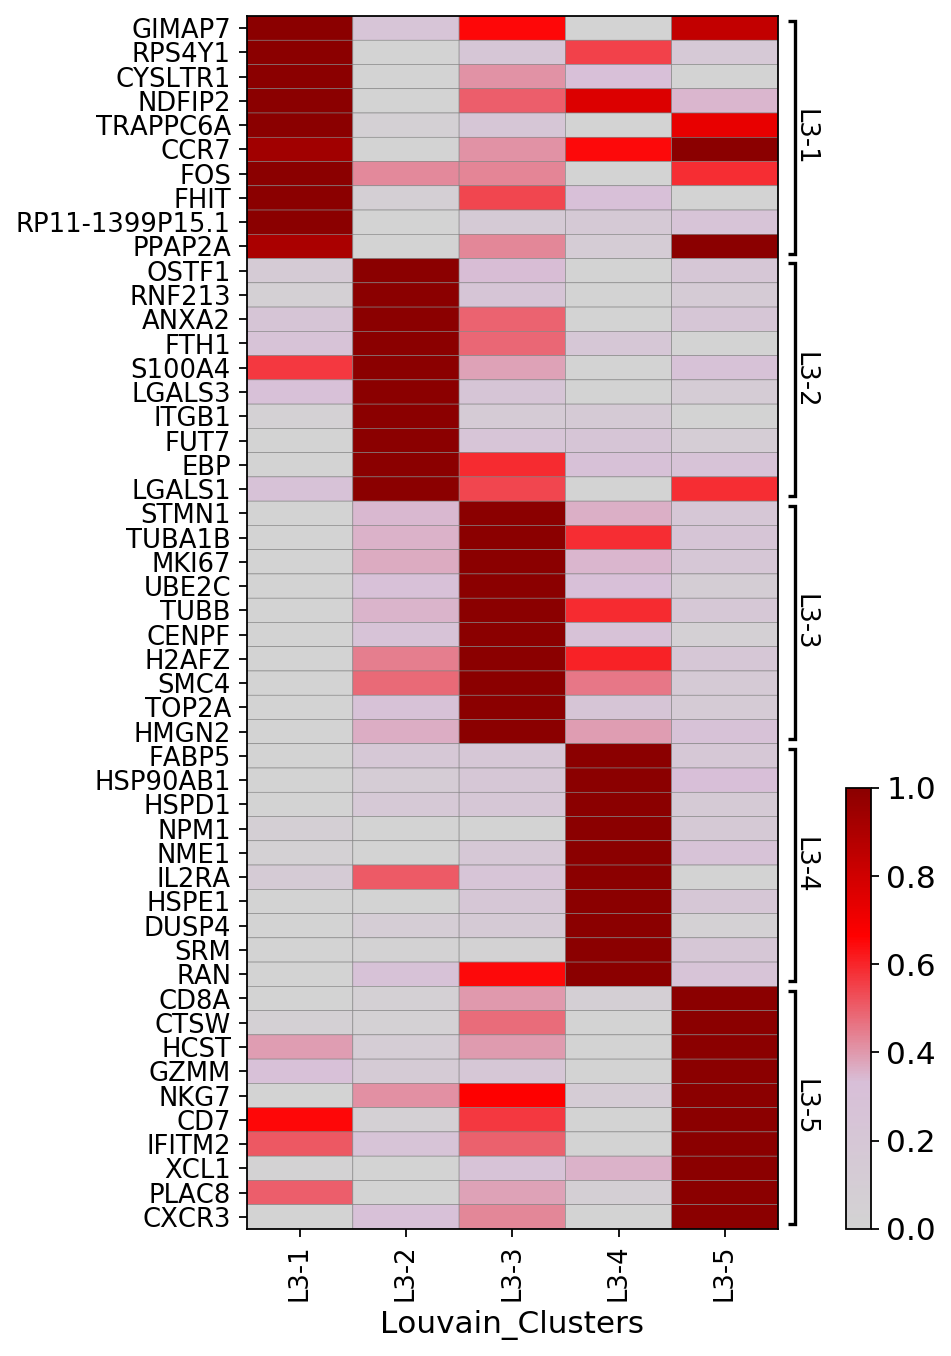

GridSpec(2, 3, height_ratios=[0, 10], width_ratios=[4.4, 0.4, 0.2])

In [10]:
gpos = [(0,9), (10,19), (20,29), (30,39), (40,49)]
glabel = DS_data.obs['Louvain_Clusters'].cat.categories
sc.pl.matrixplot(DS_data, geneDEtop10, groupby = 'Louvain_Clusters', 
                 dendrogram=False, swap_axes=True, standard_scale='var', cmap=cmap,
                var_group_positions = gpos,
                var_group_labels=glabel, figsize=(5,10), save='_DS_cluster.pdf')

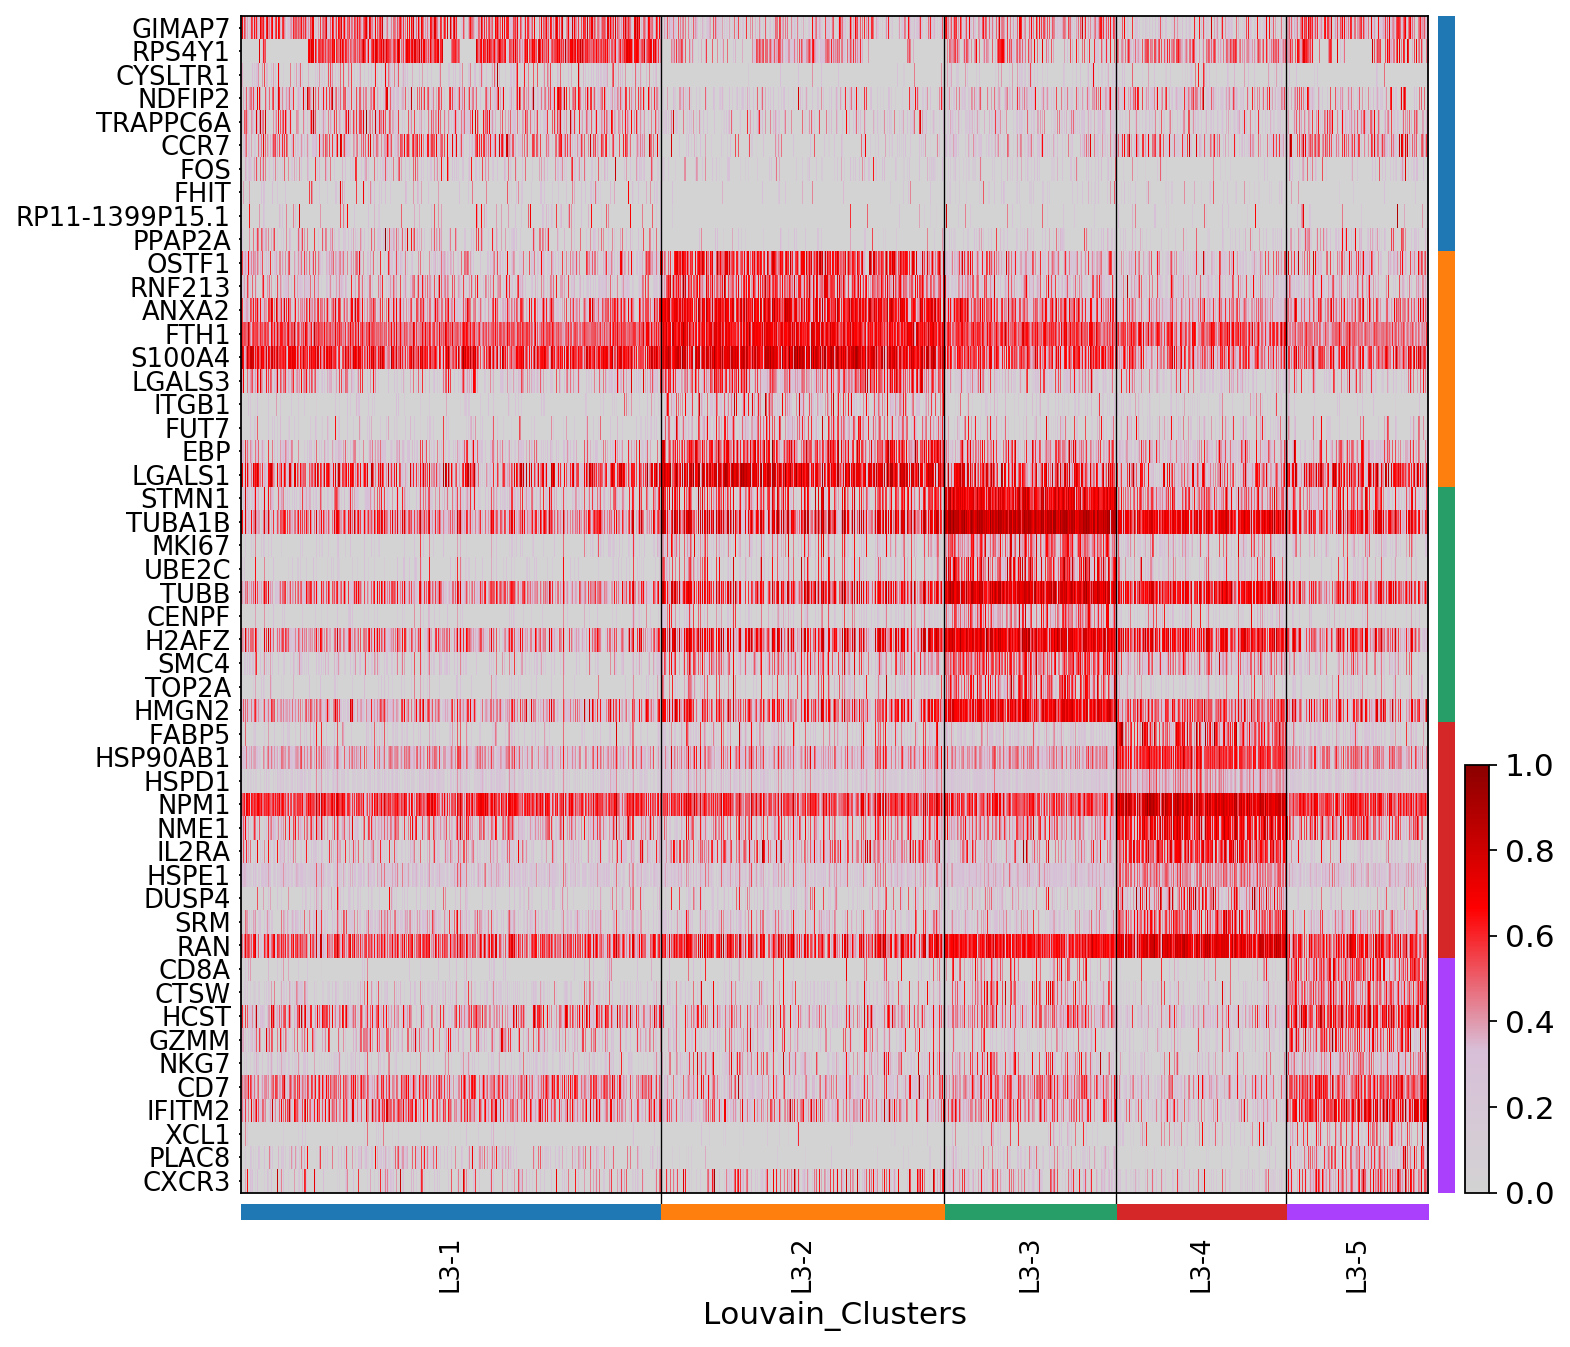

GridSpec(3, 3, height_ratios=[0, 9.87, 0.13], width_ratios=[10, 0.14, 0.2])

In [11]:
sc.pl.heatmap(DS_data, geneDEtop10, groupby = 'Louvain_Clusters', 
                 dendrogram=False, swap_axes=True, standard_scale='var', cmap=cmap,
                var_group_positions = gpos,
                var_group_labels=glabel,figsize=(10,10), save='_DS_cluster.pdf')

## Save data

In [31]:
DT_data_corrected.uns['DE_louvain'] = DT_nor.uns['rank_genes_groups']
DS_data_corrected.uns['DE_louvain'] = DS_nor.uns['rank_genes_groups']

sc.write('./write/DT_data_OL_corrected.h5ad', DT_data_corrected)
sc.write('./write/DS_data_OL_corrected.h5ad', DS_data_corrected)